# Solution: Ekman Pumping

In this exercise will apply the lesson learned about derivatives in Python to compute the Ekman transport in the ocean, and then compute the associated up- and downwelling.

In [1]:
# Import the tools we are going to need today:
import matplotlib.pyplot as plt  # plotting library
import numpy as np  # numerical library
import xarray as xr  # netCDF library
import cartopy  # Map projections libary
import cartopy.crs as ccrs  # Projections list
# Some defaults:
plt.rcParams['figure.figsize'] = (12, 5)  # Default plot size

## Data 

We are going to work again with the ``ERA5_LowRes_MonthlyAvg_uvslp.nc`` and the ``ERA5_LowRes_Invariant.nc`` files that you already downloaded from a previous unit:

In [2]:
ds = xr.open_dataset('../data/ERA5_LowRes_MonthlyAvg_uvslp.nc')
dsi = xr.open_dataset('../data/ERA5_LowRes_Invariant.nc').isel(time=0)

## Surface wind stress on the oceans

If you remember the lesson (*Oceans*), the stress exerted by surface winds on the ocean can be reasonably well approximated by the bulk formula (Marshall and Plumb, p198):

$$(\tau_{wind_x}, \tau_{wind_y}) = \rho_{air} c_D ws_{10} (u_{10}, v_{10})$$

Where $c_D$ is a bulk transfert coefficient for momentum (here we use $c_D$ = 1.5$\times$10$^{-3}$), $\rho_{air}$ is the denisty of air at the surface (here we use $\rho_{air}$ = 1.225 kg m$^3$), $ws$ is the wind speed at 10 m, and $u_{10}$ , $v_{10}$ are the components of the wind vector at 10 m height.

**Q: $\tau$ is expressed in N m$^{-2}$. verify that $c_D$ is a dimensionless quantity.**

**E: compute $\overline{\tau_x}$ and $\overline{\tau_y}$. This quantity only makes sense over the oceans. Read the invariant data and keep only the values of $\overline{\tau_x}$ and $\overline{\tau_y}$ over the oceans.**

In [3]:
ds = ds.mean(dim='month')

In [4]:
ws = (ds.u10**2 + ds.v10**2)**0.5
tau_x = 1.225 * 1.5e-3 * ws * ds.u10
tau_y = 1.225 * 1.5e-3 * ws * ds.v10
tau_x = tau_x.where(dsi.lsm == 0)
tau_y = tau_y.where(dsi.lsm == 0)

**E: compute the total wind stress $\tau = \sqrt{\tau_x^2 + \tau_y^2}$. Plot it on a map using the colormap "Greens" (so that you can compare with the lecture). Add the ($\tau_x$, $\tau_y$) vectors as arrows on top.**

In [7]:
tau = (tau_x**2 + tau_y**2)**0.5

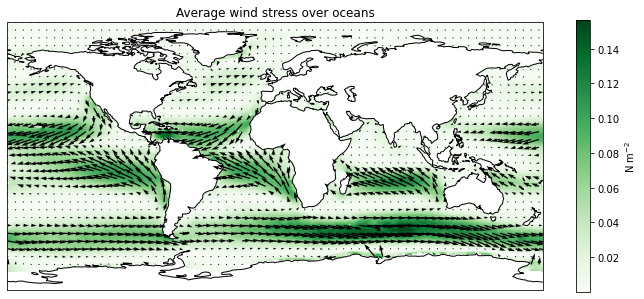

In [8]:
ax = plt.axes(projection=ccrs.PlateCarree())
tau.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=plt.get_cmap('Greens'), cbar_kwargs={'label':'N m$^{-2}$'}) 
tx, ty = tau_x[::7, ::7], tau_y[::7, ::7]
ax.quiver(tx.longitude.data, tx.latitude.data, tx.data, ty.data, transform=ccrs.PlateCarree())
ax.coastlines(); plt.title('Average wind stress over oceans');

## Ekman transport

The transport of water integrated over the Ekman layer is written (Marshall and Plumb, p200):
    
$$M_{ek} = \frac{\tau_{wind} \times \hat{z}}{f}$$

Or, in the component form:

$$m_{ek_{x}} = \frac{\tau_{wind_y}}{f} $$

$$m_{ek_{y}} = -\frac{\tau_{wind_x}}{f} $$

**E: first, we need to compute the coriolis parameter $f$:**

In [9]:
f = 2. * 7.2921150e-5 * np.sin(np.deg2rad(ds.latitude))
f = f.where((np.abs(ds.latitude) > 3) & (np.abs(ds.latitude) < 87))  # Mask out the poles and equator regions

**E: compute the components mek_x and mek_y. Plot the transport vectors on a map using the quiver() function. Discuss.**

In [10]:
mek_x = tau_y / f
mek_y = -tau_x / f

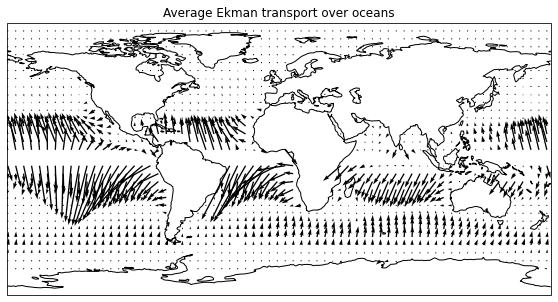

In [11]:
ax = plt.axes(projection=ccrs.PlateCarree())
tx, ty = mek_x[::7, ::7], mek_y[::7, ::7]
ax.quiver(tx.longitude, tx.latitude, tx, ty, transform=ccrs.PlateCarree())
ax.coastlines(); plt.title('Average Ekman transport over oceans');

## Ekman pumping 

The convergence (or divergence) of the Ekman transport fields generates a vertical motion at the bottom of the Ekman Layer called Ekman pumping. It is written as (Marshall and Plumb, p204):

$$w_{ek} = \frac{1}{\rho_{0}} \left( \frac{\partial}{\partial x} \frac{\tau_{wind_{y}}}{f} - \frac{\partial}{\partial y} \frac{\tau_{wind_{x}}}{f} \right)$$

with $\rho_{0}$ the density of water at the ocean surface, here assumed to be 1000 kg m$^{-3}$.

As discussed in the lesson, we shouldn't forget that we are using data defined in spherical coordinates. The partial derivatives in (x, y) are computed from spherical coordinates as:  

$$\frac{\partial}{\partial x} = \frac{1}{R \cos \varphi}\frac{\partial}{\partial\lambda}$$

$$\frac{\partial}{\partial y} = \frac{1}{R}\frac{\partial}{\partial\varphi}$$

**E: compute the partial derivatives $\frac{\partial}{\partial \lambda} \frac{\tau_{wind_{y}}}{f}$ and $-\frac{\partial}{\partial \varphi} \frac{\tau_{wind_{x}}}{f}$ out of tau_x and tau_y, and store them in the variables dlambda and dphi.** Hint: you will need *two* calls to `np.gradient()` to do this computation, each call returning one variable that you will need and another that you won't need. This second useless variable can be called "tmp" in each call for example. 

In [12]:
_, dlambda = np.gradient(tau_y / f, -np.deg2rad(0.75), np.deg2rad(0.75))
dphi, _ = np.gradient(tau_x / f, -np.deg2rad(0.75), np.deg2rad(0.75))

Now we will convert these numpy arrays back to xarray DataArrays:

In [13]:
dlambda = mek_x*0 + dlambda
dphi = mek_x*0 + dphi

**E: compute the factor fx = $\frac{1}{R \cos \varphi}$ and fy = $\frac{1}{R}$, with an Earth radius of 6371000 m.**

In [14]:
fx = 1 / (6371000 * np.cos(np.deg2rad(tau_x.latitude)))
fy = 1 / (6371000)

**E: you now have all elements to compute the Ekmann pumping "wek". What is its unit? Convert it to m yr$^{-1}$.**

In [15]:
wek = 1 / 1000 * (fx * dlambda - fy * dphi) * 60 * 60 * 24 * 365

**E: plot wek on a map. Set vmin and vmax to -50 and +50 and use another colormap (for example "BrBG"). Compare your plot with the one computed by Marshall and Plumb (p205). Discuss the major features of the plot. Where is upwelling taking place? Downwelling? Can you explain the location and strength of these features?** (click [here](https://www.dropbox.com/s/rrhtivvh7bf8ns4/pumping_map.png?dl=0) to see the plot by Marshall and Plumb)

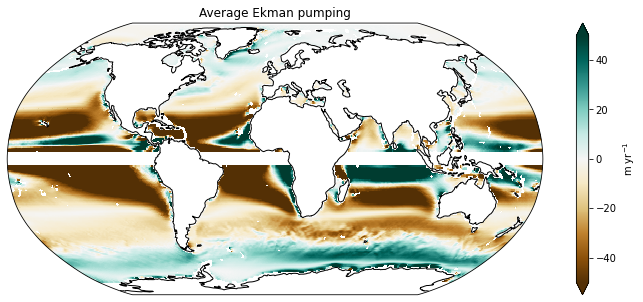

In [16]:
ax = plt.axes(projection=ccrs.Robinson())
wek.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=-50, vmax=50, cmap='BrBG', cbar_kwargs={'label':'m yr$^{-1}$'}) 
ax.coastlines(); plt.title('Average Ekman pumping');
ax.contour(wek.longitude.values, wek.latitude.values, wek.values, levels=[0], colors='k');

## To go further

Read the few pages of chapter 10.3 in the book of Marshall and Plumb (available on OLAT). In particular, we are interested in their Fig. 10.21 and equation 10.20. Can you think about a strategy to realize the same plot with our data? Without implementing it (unless you really really want to!), describe the steps needed to come to this result.